# 제6장_b 사전학습모델을 이용한 이미지 판정

**예제 코드6.12:주피터 노트북에서 그래프 표시**

In [1]:
%matplotlib inline

**예제 코드6.13:모델의 요약 확인**

In [2]:
from tensorflow.python.keras.applications.vgg16 import VGG16


# 기존의 1000 클래스의 출력을 사용하지 않기 때문에
# include_top=False로 출력층을 포함하지 않는 상태로 불러들임
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# 모델의 요약 확인. 출력층이 포함되지 않은 것을 알 수 있다.
vgg16.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________

**예제 코드 6.14:VGG16 을 이용한 모델의 작성과 학습 방법 설정**

In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten


# 모델을 편집해서 네트워크를 생성할 함수 정의
def build_transfer_model(vgg16):
    
    # 호출한 모델을 사용해서 새로운 모델 작성
    model = Sequential(vgg16.layers)

    # 호출한 가중치의 일부는 재학습하지 않도록 설정
    # 여기서는 추가한 층과 출력층에 가까운 층의 가중치만 재학습
    for layer in model.layers[:15]:
        layer.trainable = False

    # 추가할 출력 부분의 층을 구축
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# 정의한 함수를 호출해서 네트워크를 생성
model = build_transfer_model(vgg16)

**예제 코드6.15:최적화 알고리즘 등을 지정해서 모델을 컴파일**

In [4]:
from tensorflow.python.keras.optimizers import SGD


model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
# 모델 요약 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

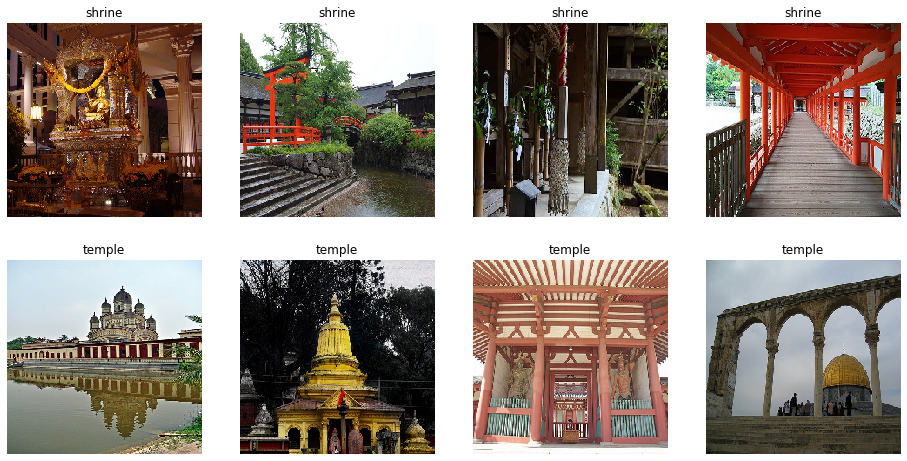

In [6]:
from utils import show_train_samples


# 학습용 데이터의 내용을 랜덤으로 표시
img_dir = 'img/shrine_temple'
show_train_samples(img_dir, classes=('shrine', 'temple'), seed=1)

**예제 코드6.16:생성기 생성**

In [7]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import preprocess_input


# 학습용 이미지를 읽어 들이기 위한 생성기 생성. 스케일 변환과 데이터 확장의 인수를 지정
idg_train = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

**예제 코드6.17:iterator 생성**　

In [8]:
# 이미지를 읽어 들이기 위한 iterator 생성

# 훈련용 데이터(학습할 때 이용)
img_itr_train = idg_train.flow_from_directory(
    'img/shrine_temple/train', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

# 검증용 데이터(학습할 때 이용)
img_itr_validation = idg_train.flow_from_directory(
    'img/shrine_temple/validation', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


**예제 코드6.18:모델 저장용 폴더 생성**

In [9]:
import os
from datetime import datetime


# 모델 저장용 폴더 준비
model_dir = os.path.join(
    'models', 
    datetime.now().strftime('%y%m%d_%H%M')
)
os.makedirs(model_dir, exist_ok=True)
print('model_dir:', model_dir)  # 저장할 폴더 이름 표시

dir_weights = os.path.join(model_dir, 'weights')
os.makedirs(dir_weights, exist_ok=True)

model_dir: models\191004_1817


**예제 코드6.19:네트워크 구조와 클래스 레이블의 저장**

In [10]:
import json
import pickle


# 네트워크 저장
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w') as f:
    json.dump(model.to_json(), f)

# 학습할 때의 정답 레이블 저장
model_classes = os.path.join(model_dir, 'classes.pkl')
with open(model_classes, 'wb') as f:
    pickle.dump(img_itr_train.class_indices, f)

**예제 코드6.20:미니 배치를 몇 개 학습하면 1에폭이 되는지 계산**

In [11]:
import math


# 미니 배치를 몇 개 학습하면 1에폭이 되는지 계산(학습할 때 지정할 필요가 있다)
batch_size = 16
steps_per_epoch = math.ceil(
    img_itr_train.samples/batch_size
)
validation_steps = math.ceil(
    img_itr_validation.samples/batch_size
)

**예제 코드6.21:콜백을 생성하고 설정**

In [12]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger


# 콜백의 설정
cp_filepath =  os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
                     cp_filepath, 
                     monitor='loss', 
                     verbose=0,
                     save_best_only=False, 
                     save_weights_only=True, 
                     mode='auto', 
                     period=5
                     )

csv_filepath =  os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

**예제 코드6.22:모델 학습**

In [13]:
n_epoch = 30

# 모델 학습
history = model.fit_generator(
    img_itr_train, 
    steps_per_epoch=steps_per_epoch, 
    epochs=n_epoch,  # 학습할 에폭수
    validation_data=img_itr_validation, 
    validation_steps=validation_steps,
    callbacks = [cp, csv]
)

Epoch 1/30
38/38 [==============================] - 20s 523ms/step - loss: 0.6427 - acc: 0.6300 - val_loss: 0.4449 - val_acc: 0.8450
Epoch 2/30
38/38 [==============================] - 9s 233ms/step - loss: 0.4977 - acc: 0.7450 - val_loss: 0.3466 - val_acc: 0.9150
Epoch 3/30
38/38 [==============================] - 9s 236ms/step - loss: 0.4002 - acc: 0.8167 - val_loss: 0.2813 - val_acc: 0.9150
Epoch 4/30
38/38 [==============================] - 9s 226ms/step - loss: 0.3553 - acc: 0.8583 - val_loss: 0.2556 - val_acc: 0.9100
Epoch 5/30
38/38 [==============================] - 9s 244ms/step - loss: 0.3402 - acc: 0.8617 - val_loss: 0.2535 - val_acc: 0.9050
Epoch 6/30
38/38 [==============================] - 9s 233ms/step - loss: 0.3261 - acc: 0.8783 - val_loss: 0.2349 - val_acc: 0.9150
Epoch 7/30
38/38 [==============================] - 9s 226ms/step - loss: 0.3018 - acc: 0.8817 - val_loss: 0.2145 - val_acc: 0.9300
Epoch 8/30
38/38 [==============================] - 9s 232ms/step - loss: 0

**예제 코드 6.23:학습한 모델을 사용해서 예측** 

In [14]:
from utils import load_random_imgs

# 학습 결과를 산출(추론)
test_data_dir = 'img/shrine_temple/test/unknown'
x_test, true_labels = load_random_imgs(
    test_data_dir, 
    seed=1
)
x_test_preproc= preprocess_input(x_test.copy())/255.
probs = model.predict(x_test_preproc)

probs

array([[0.00648531],
       [0.3120026 ],
       [0.15467483],
       [0.5225404 ],
       [0.18845674],
       [0.9929407 ],
       [0.00364298],
       [0.99995697]], dtype=float32)

In [15]:
# 클레스 레이플 확인
print('class_indices:', img_itr_train.class_indices)

class_indices: {'shrine': 0, 'temple': 1}


**예제 코드6.24:결과를 평가**

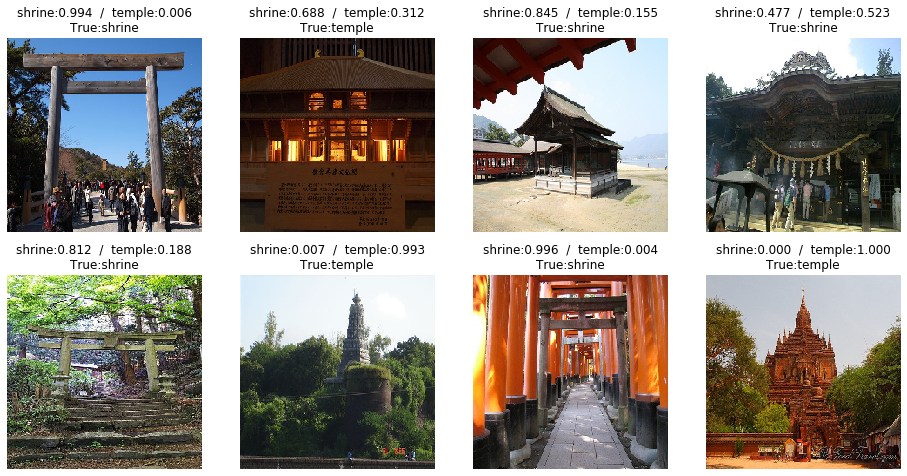

In [16]:
from utils import show_test_samples


# 평가용이미지 표시
show_test_samples(
    x_test, probs, 
    img_itr_train.class_indices, 
    true_labels
)

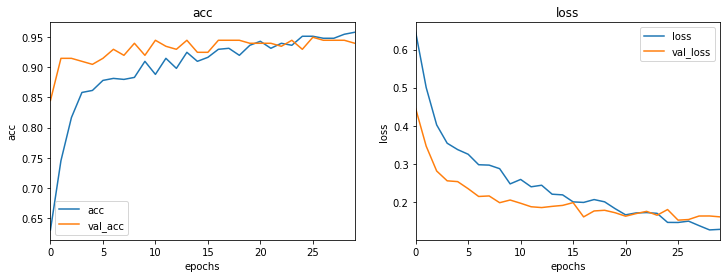

In [17]:
from utils import plot_learningcurve_from_csv


# 학습 곡선 표시
plot_learningcurve_from_csv(csv_filepath)